In [1]:
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
from itertools import chain, repeat

### Functions

In [2]:
def ncycles(iterable, n):
    "Returns the sequence elements n times"
    return chain.from_iterable(repeat(tuple(iterable), n))

### Plot Scenario Data

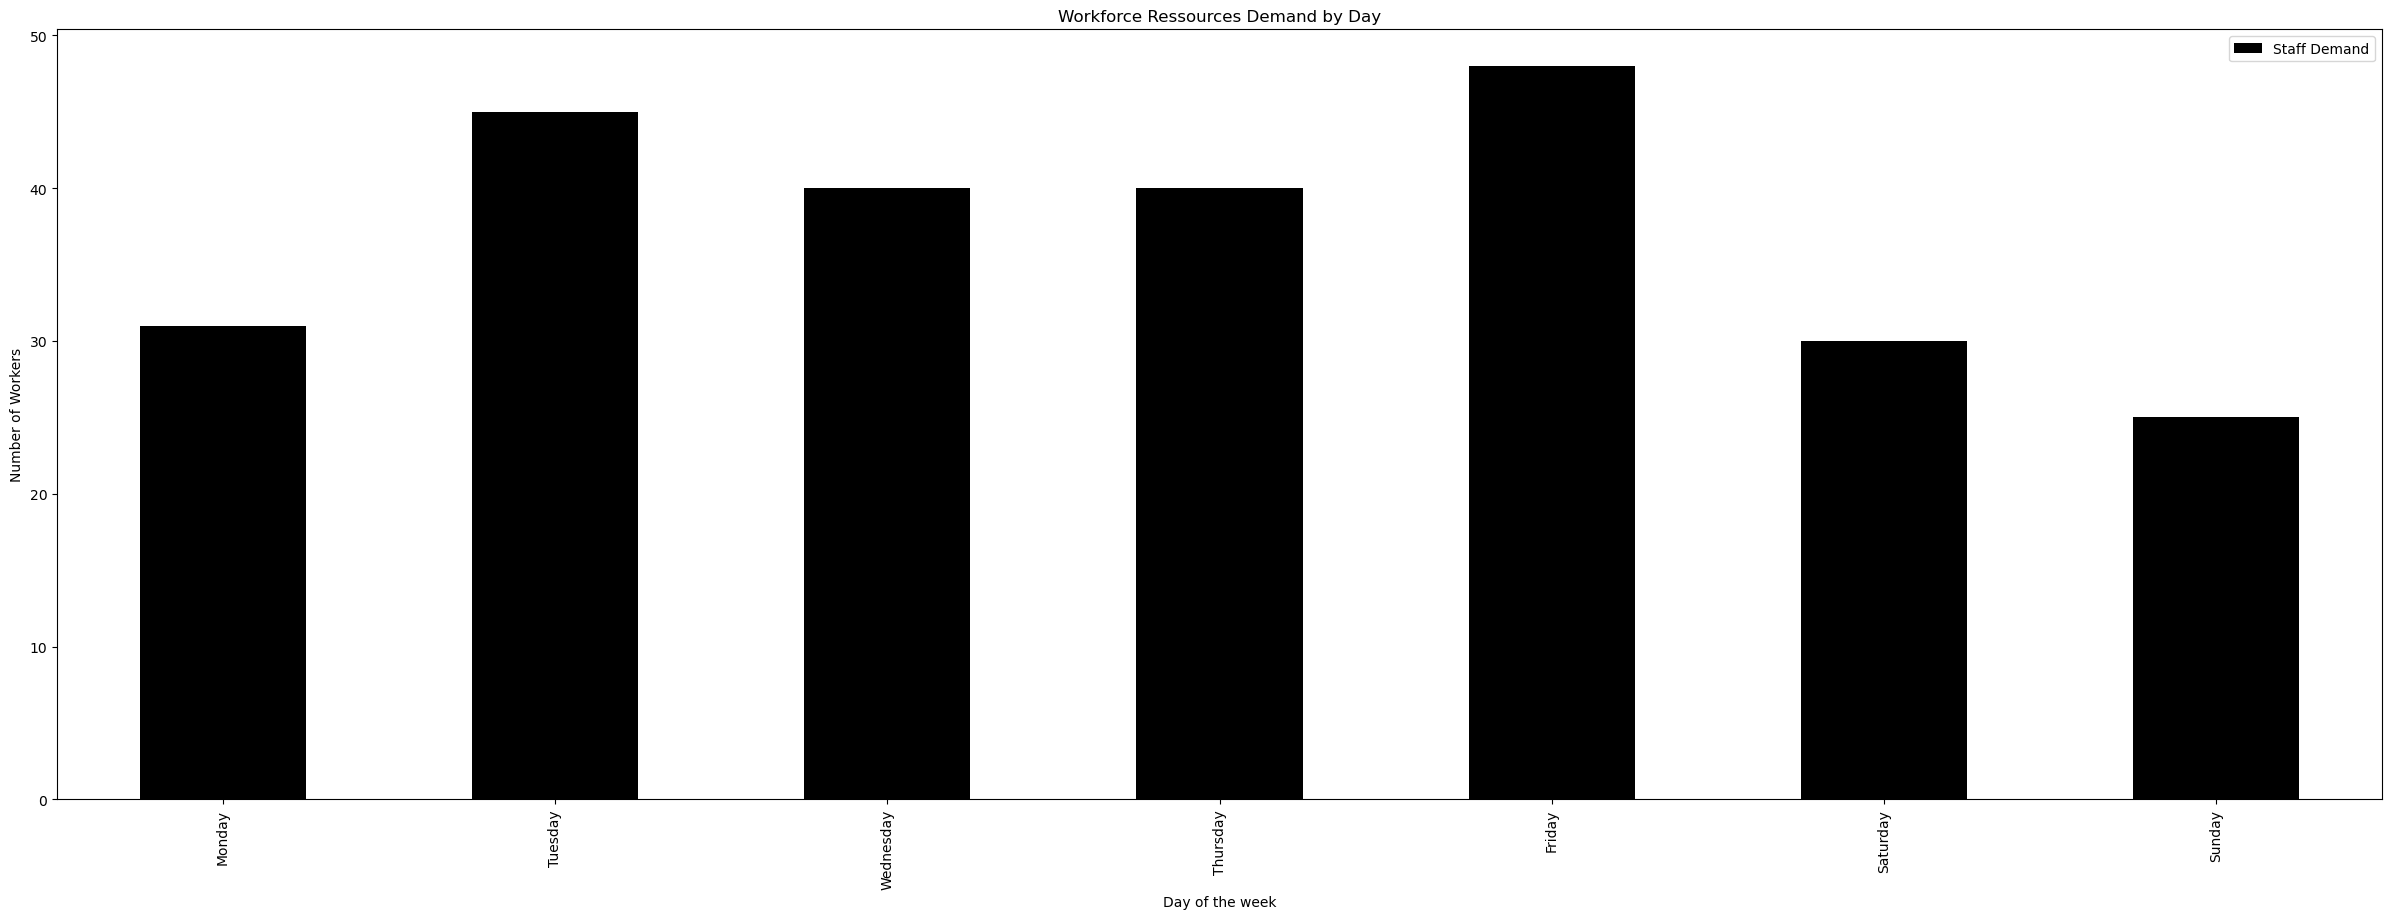

In [3]:
# Staff needs per Day (FTE)
n_staff = [31, 45, 40, 40, 48, 30, 25]
jours = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Staff
df_staff = pd.DataFrame({'Days': jours, 'Staff Demand':n_staff})
df_staff[['Days', 'Staff Demand']].plot.bar(x='Days', figsize = (30, 10), fill=True, color='black')
plt.title('Workforce Ressources Demand by Day')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()

### Optimization: Minimize Staff
#### Prepare circular lists and workdays

In [4]:
# Create circular list of days
n_days = [i for i in range(7)]
n_days_c = list(ncycles(n_days, 3)) 

# Working days
list_in = [[n_days_c[j] for j in range(i , i + 5)] for i in n_days_c]

# Days off
list_excl = [[n_days_c[j] for j in range(i + 1, i + 3)] for i in n_days_c]

#### Build the model, add constraints, set objective and then solve

In [5]:
# The class has been initialize, and x, and days defined
model = LpProblem("Minimize Staffing", LpMinimize)

# Create Variables
start_jours = ['Shift: ' + i for i in jours]
x = LpVariable.dicts('shift_', n_days, lowBound=0, cat='Integer')

# Define Objective
model += lpSum([x[i] for i in n_days])

# Add constraints
for d, l_excl, staff in zip(n_days, list_excl, n_staff):
    model += lpSum([x[i] for i in n_days if i not in l_excl]) >= staff

# Solve Model
model.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[model.status])

/Users/Mehrdadi/Desktop/udemy/env/lib/python3.9/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --cpxlp /var/folders/zc/lhpyx9cd2pdg5g1k0srmc8880000gp/T/a8b9680ec8db4a0ea489fa90157c4c36-pulp.lp
 -o /var/folders/zc/lhpyx9cd2pdg5g1k0srmc8880000gp/T/a8b9680ec8db4a0ea489fa90157c4c36-pulp.sol
Reading problem data from '/var/folders/zc/lhpyx9cd2pdg5g1k0srmc8880000gp/T/a8b9680ec8db4a0ea489fa90157c4c36-pulp.lp'...
7 rows, 7 columns, 35 non-zeros
7 integer variables, none of which are binary
29 lines were read
GLPK Integer Optimizer, v4.65
7 rows, 7 columns, 35 non-zeros
7 integer variables, none of which are binary
Preprocessing...
7 rows, 7 columns, 35 non-zeros
7 integer variables, none of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
7 rows, 7 columns, 35 non-zeros
      0: obj =   0.000000000e+00 inf =   2.59

#### Show the solution

In [6]:
# How many workers per day ?
dct_work = {}
dico_work = {}
for v in model.variables():
    dct_work[int(v.name[-1])] = int(v.varValue)
    dico_work[v.name] = int(v.varValue)
dico_work

{'shift__0': 13,
 'shift__1': 15,
 'shift__2': 7,
 'shift__3': 0,
 'shift__4': 13,
 'shift__5': 0,
 'shift__6': 5}

#### Total number of FTE

In [7]:

# Show workers schedule
dict_sch = {}
for day in dct_work.keys():
    dict_sch[day] = [dct_work[day] if i in list_in[day] else 0 for i in n_days]
df_sch = pd.DataFrame(dict_sch).T
df_sch.columns = jours
df_sch.index = start_jours
# The optimized objective function value is printed to the screen
print("Total number of Staff = ", pulp.value(model.objective))

Total number of Staff =  53


#### Show visibility at the shift level

In [8]:
# Detailed
df_sch

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Shift: Monday,13,13,13,13,13,0,0
Shift: Tuesday,0,15,15,15,15,15,0
Shift: Wednesday,0,0,7,7,7,7,7
Shift: Thursday,0,0,0,0,0,0,0
Shift: Friday,13,13,0,0,13,13,13
Shift: Saturday,0,0,0,0,0,0,0
Shift: Sunday,5,5,5,5,0,0,5


In [9]:
# Sum by day
df_sch.sum(axis =0)

Monday       31
Tuesday      46
Wednesday    40
Thursday     40
Friday       48
Saturday     35
Sunday       25
dtype: int64

#### Show Workforce Supply vs. Demand

In [11]:
df_supp = df_staff.copy().set_index('Days')
df_supp['Staff Supply'] = df_sch.sum(axis = 0)
df_supp['Extra_Ressources'] = df_supp['Staff Supply'] - df_supp['Staff Demand']
df_supp.to_csv('/Users/Mehrdadi/test.csv')

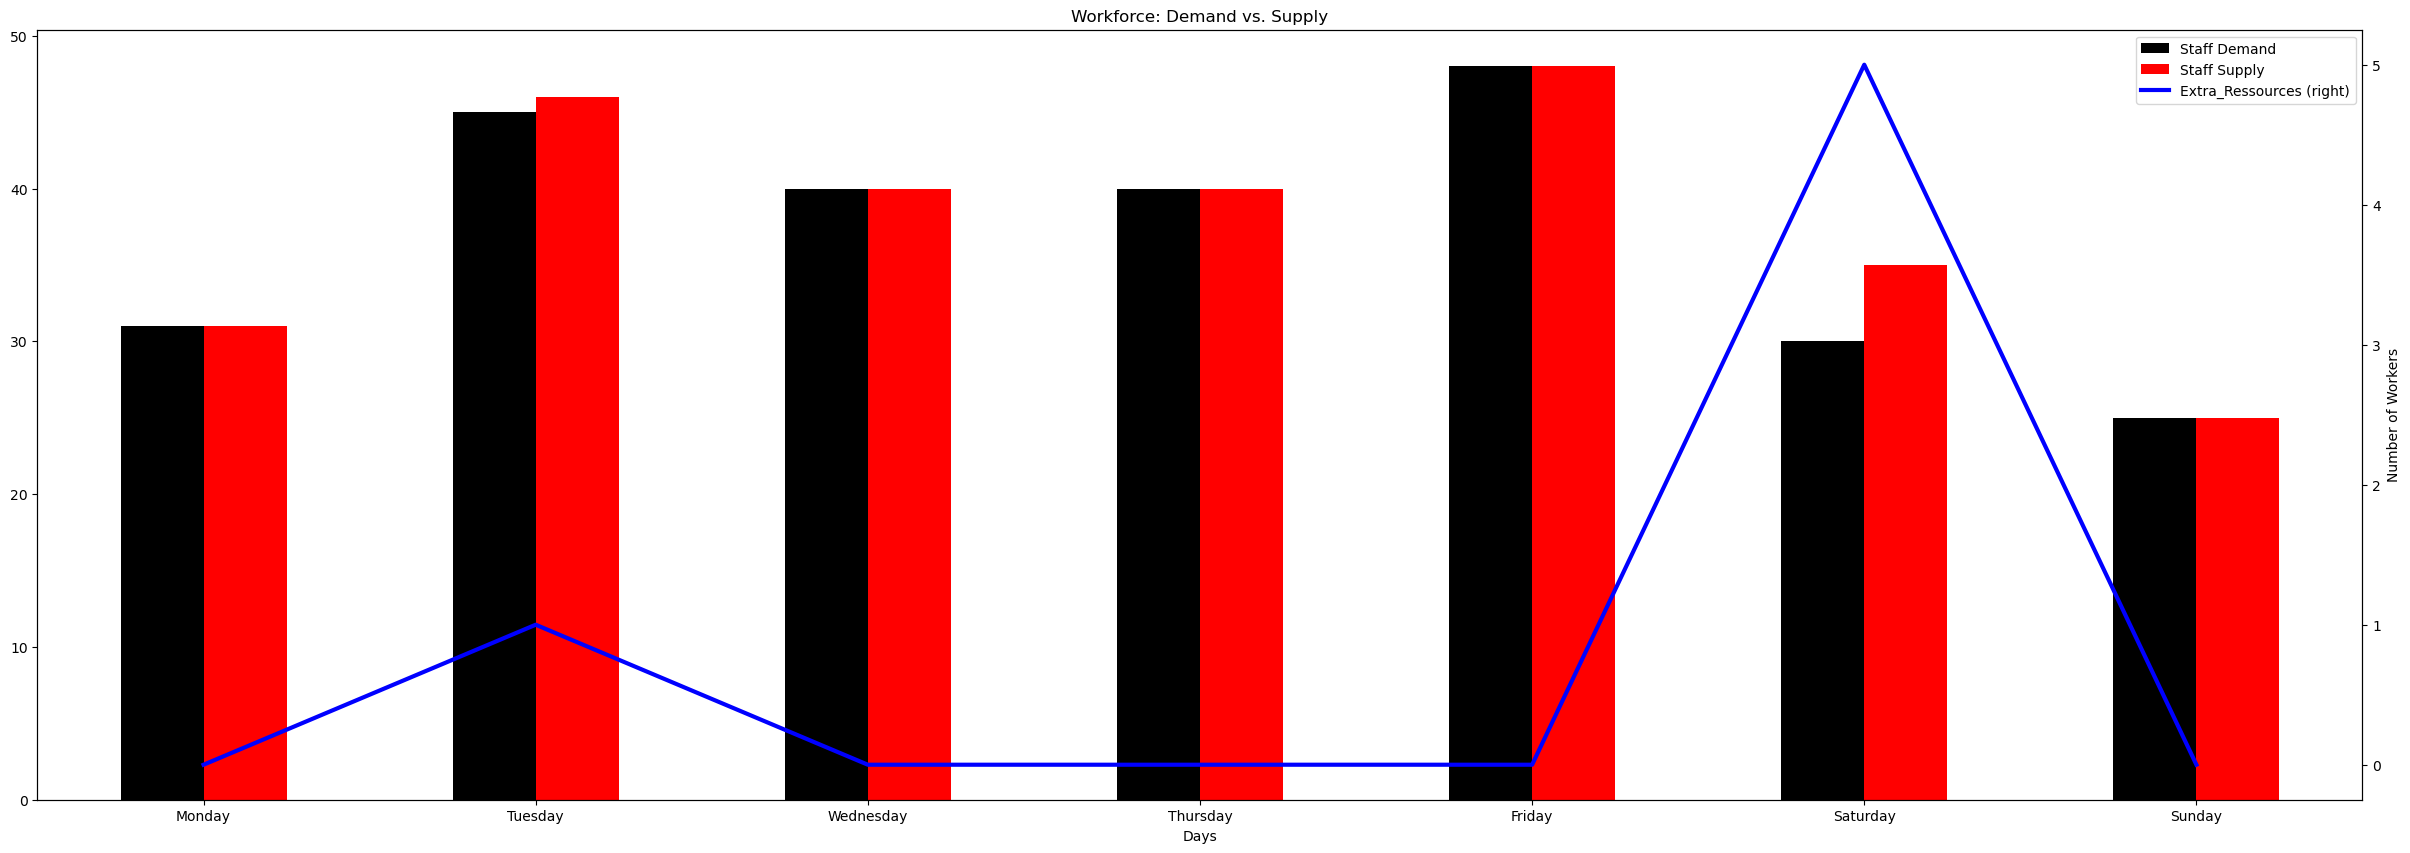

In [12]:
# Staff
ax = df_supp.plot.bar(y=['Staff Demand', 'Staff Supply'], figsize = (30, 10), fill=True, color=['black', 'red'])
df_supp.plot(y=['Extra_Ressources'], color=['blue'], secondary_y = True, ax = ax, linewidth = 3)
plt.title('Workforce: Demand vs. Supply')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()